In [1]:
%load_ext autoreload
%autoreload 2

# Segmentation

## Règles

_Avant de s’interroger sur les responsabilités d’un algorithme, il faut être en mesure d’identifier quel algorithme est la source de telle décision. Ainsi, en parallèle des conférences, la société civile est invitée dans le cadre d’un Hackathon, à contribuer à la résolution de ce problème ouvert via des techniques d’intelligence artificielle._
_Le Hackathon propose un cas simplifié, mais réaliste, de plateforme de livraison de plats cuisinés. La plateforme affiche à l’utilisateur un tarif unique pour chaque livraison, depuis un restaurant jusqu’au lieu de collecte. Plusieurs options sont possibles pour l'établissement de ce tarif : le restaurant décide quelle option de livraison et/ou tarification de livraison s’applique à lui parmi différents algorithmes proposés par la plateforme ou la tarification est complètement à la main du restaurant._

_Pour comprendre les responsabilités à l’œuvre, les participants inscrits auront pour mission de détecter à partir du jeu de données fourni quel algorithme fixe quelle tarification. Afin d’aider les participants, le jeu de données contient des informations récupérées sur la plateforme fictive (e.g. le lieu de livraison) comme des données contextuelles (e.g. des informations sur la météo locale). Toute donnée supplémentaire apportée par les candidats est bienvenue._

## Méthodologie

## Objectif visé
Déterminer, pour chaque commande, le mode de tarification utilisé (variable caché) étant donné le tarif affiché à l'utilisateur (qui est notre observable).

### Données utilisées (et sources)
Météo (jdd fourni)
Géolocalisation des points de livraison (jdd fourni)
Géolocalisation des commerces (jdd fourni)
Jour et heure (jdd fourni)

### Spécifications techniques du code
python3.10
sklearn==1.1.0

## Feature engineering

In [2]:
import pandas as pd
tarifs = pd.read_csv("tarifs.csv")

In [3]:
tarifs.head()

,observation_uuid,start_lat,start_lon,start_code_postal,end_lat,end_lon,end_code_postal,rain,heat,day_of_week,hour,minute,fee
0,0d742256-0b36-f3cd-0acf-eba4441030ae,48.8406,2.3220,75014,48.8262,2.3192,75014,2,5,Saturday,13,44,1.69
1,743c7e9d-2fde-b035-2452-bc39dbf2eed1,48.8472,2.3527,75005,48.8337,2.3880,75012,9,3,Tuesday,14,14,1.59
2,43893bc5-449c-56ef-3857-ebe679ffa869,48.9015,2.3704,75019,48.8814,2.3484,75009,1,9,Sunday,14,39,2.19
3,284884a2-55e5-c1d9-b036-4ad9ee5be9b9,48.8504,2.2902,75015,48.8716,2.2811,75016,6,2,Thursday,12,46,1.79
4,a0ce5b5f-ca56-3921-f942-2f1efed97f9e,48.8583,2.3894,75011,48.8623,2.3426,75001,2,6,Friday,13,38,2.09


#### Adding restaurant id.
#### Also addd addresses (?) (seem to be useless. Maybe the addressed are anonymized ?)

In [4]:
tarifs["id"] = tarifs.apply(lambda row: str(row["start_lat"]) + str(row["start_lon"]), axis=1)

In [5]:
"""
tarifs["lat"] = tarifs["start_lat"]
tarifs["lon"] = tarifs["start_lon"]
tarifs.to_csv("tarifs_geo.csv")
!curl -X POST -F data=@tarifs_geo.csv https://api-adresse.data.gouv.fr/reverse/csv/ > tarifs_adresses.csv
"""


'\ntarifs["lat"] = tarifs["start_lat"]\ntarifs["lon"] = tarifs["start_lon"]\ntarifs.to_csv("tarifs_geo.csv")\n!curl -X POST -F data=@tarifs_geo.csv https://api-adresse.data.gouv.fr/reverse/csv/ > tarifs_adresses.csv\n'

### Distance

In [6]:
import numpy as np

In [7]:
# Création de la colonne "distance au point de livraison"
tarifs["d"] = np.sqrt((tarifs["end_lon"]-tarifs["start_lon"])**2 + (tarifs["end_lat"]-tarifs["start_lat"])**2)

## Arrondissement

In [8]:
# it works because the last 2 digits of code INSEE equals the arrondissement number for Paris
tarifs["arrondissement"] = tarifs.apply(lambda row: str(row["end_code_postal"])[-2:], axis=1)

## Jour

In [9]:
day_dict = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
tarifs["day_code"] = tarifs.apply(lambda row: day_dict[row["day_of_week"]], axis=1)
df = tarifs[["id", "rain", "heat", "day_code", "hour", "fee", "d", "arrondissement"]]
df.head(10)

,id,rain,heat,day_code,hour,fee,d,arrondissement
0,48.84062.322,2,5,6,13,1.69,0.014670,14
1,48.84722.3527,9,3,2,14,1.59,0.037793,12
2,48.90152.3704,1,9,7,14,2.19,0.029799,09
3,48.85042.2902,6,2,4,12,1.79,0.023071,16
4,48.85832.3894,2,6,5,13,2.09,0.046971,01
5,48.84842.2891,2,6,5,12,1.89,0.020339,07
6,48.84242.3476,3,2,6,12,2.09,0.029937,14
7,48.83632.3069,3,1,4,14,2.59,0.044840,16
8,48.88552.3214,1,4,5,13,3.29,0.040730,15
9,48.84572.3192,2,7,4,12,2.49,0.041856,17


In [10]:
# prise en compte de la météo

## Méthodologie de validation

In [11]:
from sklearn.model_selection import train_test_split
## à faire plus tard avant de soumettre

## Analyse de l'algorithme

In [12]:
# Nos idées, à mettre plus tard dans le README.md (à la fin du hackathon)

### Modèle constant (mod 1) et modèle rain - deux valeurs selon qu'on est  rain>=6 ou non  (mod 2)

In [19]:
df["rain_thresh"] = False
df.loc[df["rain"]>=6,"rain_thresh"]=1 # values 6, 7, 8, 9
restaurant_model = df[["fee", "id"]].groupby("id").nunique().reset_index()
restaurant_model["model"] = 0
restaurant_model.loc[restaurant_model["fee"]==1, "model"] = 1
restaurant_model

/tmp/ipykernel_26716/2720529058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rain_thresh"] = False
/tmp/ipykernel_26716/2720529058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["rain"]>=6,"rain_thresh"]=1 # values 6, 7, 8, 9


,id,fee,model
0,48.81712.3343,4,0
1,48.81892.3484,5,0
2,48.81982.3329,7,0
3,48.81982.3459,6,0
4,48.81982.3503,7,0
...,...,...,...
595,48.89932.3477,7,0
596,48.89952.3286,6,0
597,48.89962.3456,5,0
598,48.90142.386,7,0


In [20]:
df_annotated = pd.merge(df, restaurant_model[["id", "model"]], left_on="id", right_on="id")

### Modèle à deux valeurs

## Visualisation de données

In [38]:
"""
import plotly.express as px
counts, bins = np.histogram(df_annotated.fee, bins=301)
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'fee', 'y':'count'})
fig.show()
"""

"\nimport plotly.express as px\ncounts, bins = np.histogram(df_annotated.fee, bins=301)\nbins = 0.5 * (bins[:-1] + bins[1:])\n\nfig = px.bar(x=bins, y=counts, labels={'x':'fee', 'y':'count'})\nfig.show()\n"

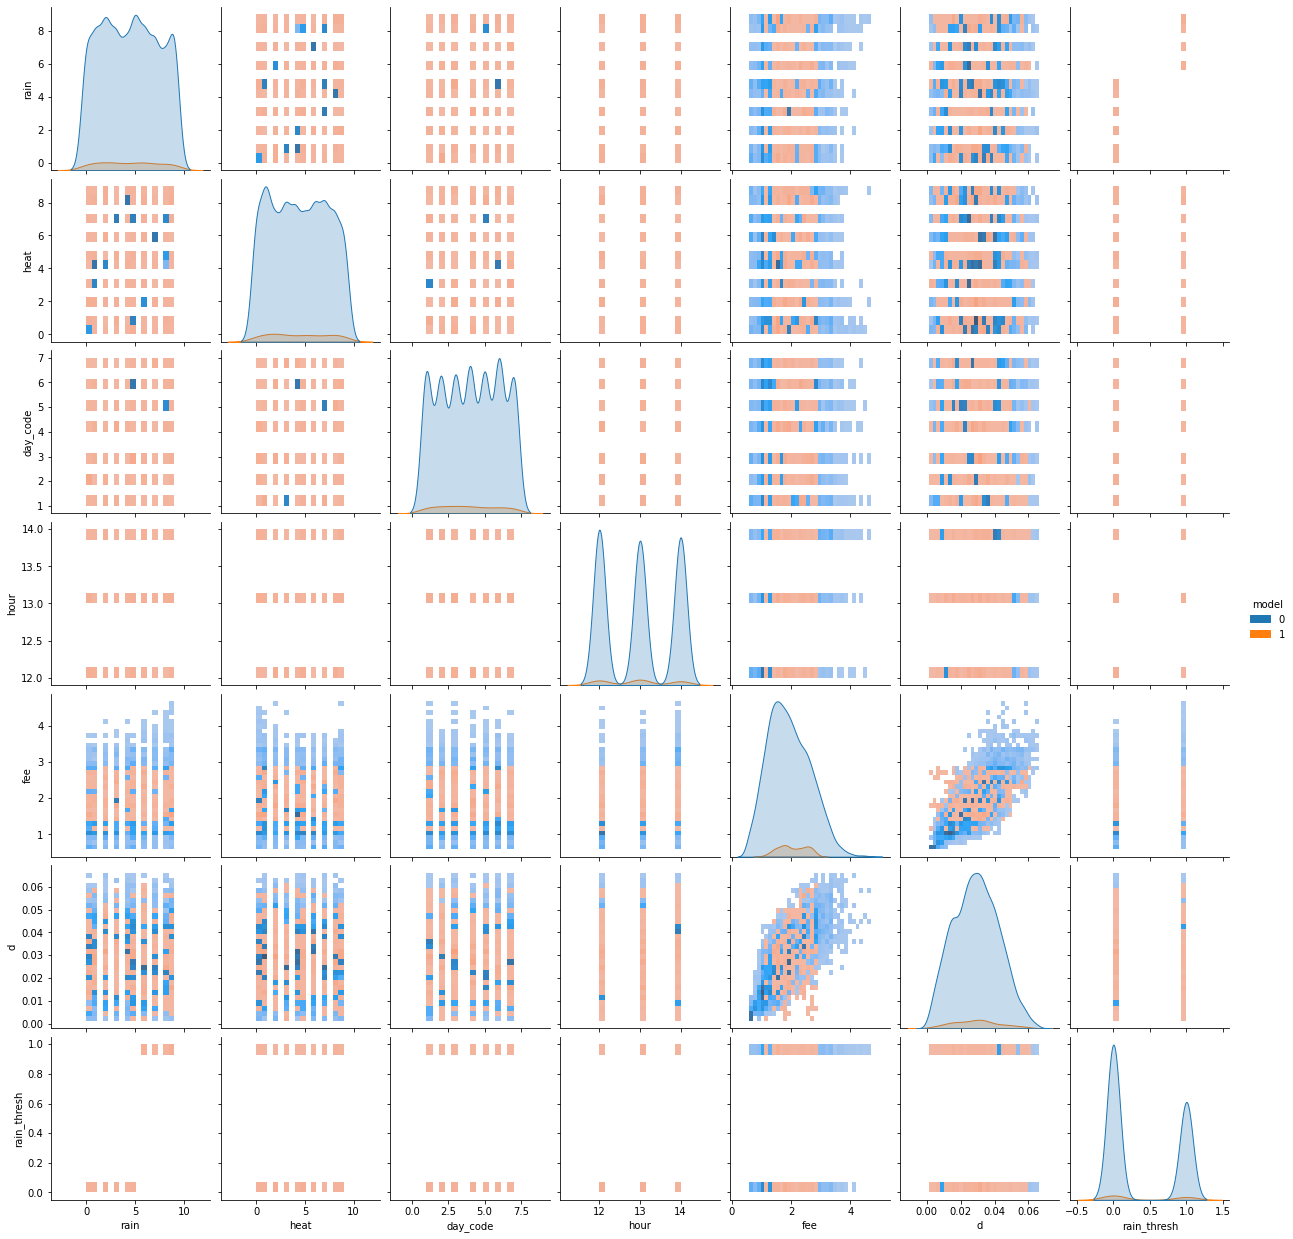

In [40]:
import seaborn as sns
import plotly # https://plotly.com/python/

sns.pairplot(df_annotated, hue="model", kind="hist", diag_kind="kde")#, palette="id") #, hue="col1", palette="col2")
# visualisation 2D à creuser : (distance OU temps OU nb course) x commmission 
# notion éventuelle de bonus pour certaines courses à certains moments ou certains endroits 
# bonus : (regarder la série temporelle de la tarification moyenne), ou la distribution géographique

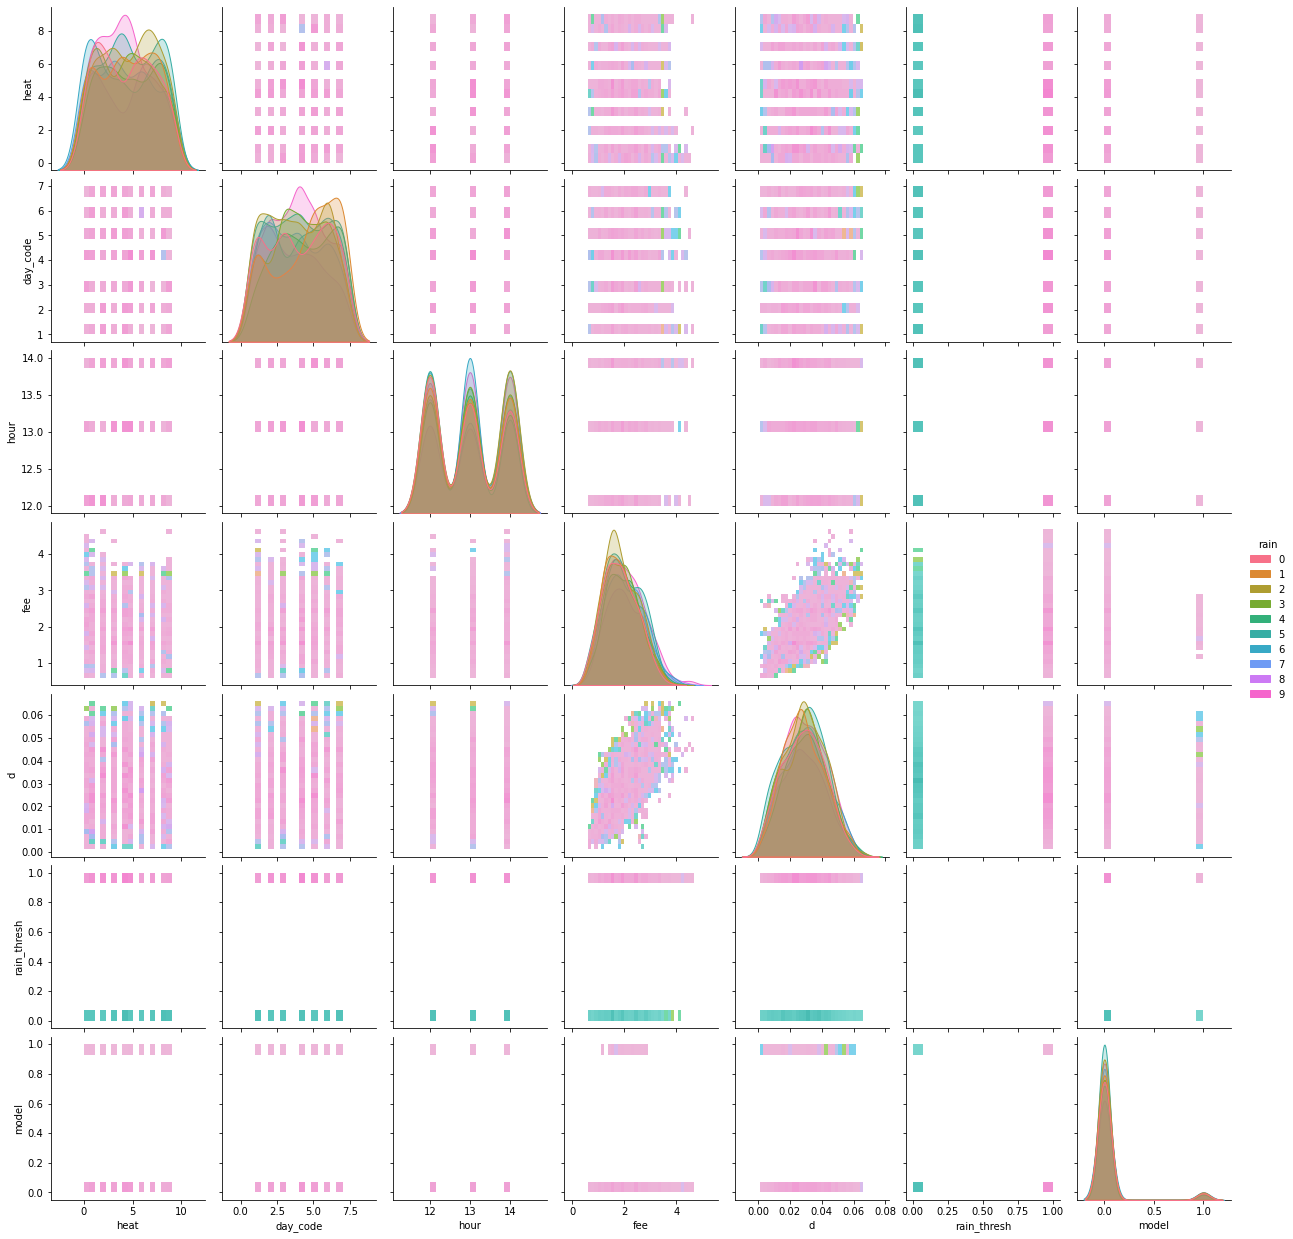

In [42]:
import seaborn as sns
import plotly # https://plotly.com/python/

sns.pairplot(df_annotated, hue="rain", kind="hist", diag_kind="kde", palette=sns.color_palette("husl", 10))

### Hypothese 0: constant prices

In [ ]:
df[["fee", "id"]].groupby("id").nunique().values

### Modélisation avec des ellipses pour gérer le bruit sur la distance (pour plus tard ?)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
model = BayesianGaussianMixture(n_components=3, covariance_type="tied")
#model.fit(df[["d", "fee"]])
# https://runebook.dev/fr/docs/scikit_learn/modules/mixture#bgmm (traduction de la doc scikit-learn)
# https://scikit-learn.org/dev/modules/mixture.html#mixture
# make_pipeline(StandardScaler(), model)